# Performance Gain 2: Random-Scan Uniform Slice Sampling
This experiment serves to showcase how much PATT can improve the performance of *random-scan uniform slice sampling* (RSUSS) ([Neal (2003)](https://projecteuclid.org/journalArticle/Download?urlId=10.1214%2Faos%2F1056562461)). Naturally, this is done by letting "plain" RSUSS compete with PATT-RSUSS on some fixed target, which for simplicity we chose to be a simple toy example.

As Neal did not use the term RSUSS, we clarify that we mean the method which in each iteration draws a threshold in the usual uniform slice sampling fashion, then randomly chooses a dimension $i \in \{1,...,d\}$ and updates its current state $x_{n-1}$ by performing stepping-out and shrinkage procedures on the unique line through $x_{n-1}$ on which only the $i$-th vector entry varies. Clearly, RSUSS can be viewed as an axis-aligned analogue to HRUSS.

The target distribution we are considering in this experiment is $\nu = \mathcal{N}_d(0, \Sigma)$ with 
$$\Sigma_{i,j} = \begin{cases} 1 & i=j , \\ 0.9 & i \neq j , \end{cases}$$
i.e. a mean-zero Gaussian with strongly correlated variables. We note that RSUSS, like HRUSS, is a hybrid variant of uniform slice sampling and consequently unaffected by *centering*. Unlike HRUSS, however, RSUSS is also mostly unaffected by inconsistent coordinate variances, in that their presence negative influences its TDE/it, but does not have any effect on its sample quality. *Variance adjustments* can therefore not be expected to substantially improve its overall performance either. Despite these far-reaching "immunities", PATT can be of use to RSUSS: As a result of the axis-aligned updates, RSUSS is particularly sensitive to strong correlations between the target variables, but with *covariance adjustments*, PATT can (in principle) remove such correlations entirely.

In [1]:
path_prefix = "../plots/performance_gain_rsuss_"

In [2]:
from patt_mcmc import patt_rsuss
from random_scan_uniform_slice_sampling import parallel_rsuss
import mcmc_utils as mcu
import plotting_functions as pfs
import numpy as np
import numpy.linalg as alg
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
d = 50
n_chains = 10
n_burn = int(1e4)
n_its = int(4e4)
x_0s = rnd.normal(size=(n_chains,d))

In [4]:
corr = 0.9
cov = np.full((d,d), corr) + (1 - corr) * np.identity(d)
inv_cov = alg.inv(cov)

def log_density(x):
    return -np.inner(x, inv_cov @ x) / 2

### Run Plain RSUSS

In [5]:
w_plain = 1

In [6]:
samples_tmp, tde_tmp = parallel_rsuss(
    log_density,
    n_chains,
    n_its + n_burn,
    x_0s,
    w_plain,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Starting parallel sampling...


100%|██████████████████████████████████| 50000/50000 [00:03<00:00, 14698.78it/s]


Processing returns and terminating...


In [7]:
burn_tde_plain = tde_tmp[:n_burn+1]
tde_plain = tde_tmp[n_burn:]
burn_in_plain = samples_tmp[:n_burn+1]
samples_plain = samples_tmp[n_burn:]

### Run PATT-RSUSS

In [8]:
w_burn = 1
w_att = np.sqrt(d)

In [9]:
ret_dic = patt_rsuss(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0s,
    cov_mode="cov",
    w_burn=w_burn,
    w_att=w_att,
)

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for init burn-in period...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/40001 [00:00<?, ?it/s]

Assembling output...


In [10]:
burn_in_patt = ret_dic['burn-in']
burn_tde_patt = ret_dic['tde_cnts_burn']
samples_patt = ret_dic['samples']
tde_patt = ret_dic['tde_cnts']
means = ret_dic['means']
covs = ret_dic['covs']
schedule = ret_dic['schedule']

### Analyze Sampling Performance
**Note:** We do not consider IATs w.r.t. univariate marginals here because each each individual coordinate of the state is only rarely updated by RSUSS, which massively inflates the corresponding IATs, ultimately making them ill-suited for computation.

In [11]:
snames = ["plain RSUSS", "PATT-RSUSS"]
burn_samples = [burn_in_plain, burn_in_patt]
samples = [samples_plain, samples_patt]
burn_tde = [burn_tde_plain, burn_tde_patt]
tde = [tde_plain, tde_patt]

In [12]:
burn_radii = mcu.get_radii_list(burn_samples)
radii = mcu.get_radii_list(samples)
flat_steps = mcu.get_flat_steps_list(samples)

In [13]:
mean_burn_tde = mcu.mean_tde_list(burn_tde)
mean_tde = mcu.mean_tde_list(tde)
maxls = [int(2e4), int(1e3)]
iats = mcu.iat_multi_chain_list(radii, maxls)
msss = mcu.mss_list(samples)

In [14]:
pd.DataFrame(
    np.array([
        snames,
        np.round(mean_burn_tde, 2),
        np.round(mean_tde, 2),
        np.round(iats, 2),
        np.round(msss, 2),
        np.round(mean_tde * iats, 2), # TDE per effective sample = total TDE / total ES = TDE/it / ES/it = TDE/it / IAT
        np.round(mean_tde / msss, 2) # = TDE/it * (its to move by 1) = TDE to move by 1
    ]).T,
    columns = [
        "Sampler",
        "TDE/it burn-in",
        "TDE/it",
        "IAT",
        "MSS",
        "TDE/ES",
        "TDE/MSS",
    ]
)

,Sampler,TDE/it burn-in,TDE/it,IAT,MSS,TDE/ES,TDE/MSS
0,plain RSUSS,4.9,4.89,5895.62,0.34,28858.31,14.34
1,PATT-RSUSS,4.9,5.0,125.22,0.54,626.27,9.26


We can see that PATT-RSUSS vastly outperforms RSUSS in terms of IAT and at least has a significant advantage over it in the MSS category. Meanwhile, PATT appears to have little effect on the TDE/it (at least with the RSUSS hyperparameter choices we made). Altogether, this leads to an improvement of far over an order of magnitude in the cost-adjusted performance metric TDE/ES.

Like HRUSS in the previous experiment, RSUSS cannot be expected to work arbitrarily well here (even when combined with PATT), because it is also based on uniform slice sampling, and therefore inherits the same curse of dimensionality (see the HRUSS experiment for details).

### Plotting

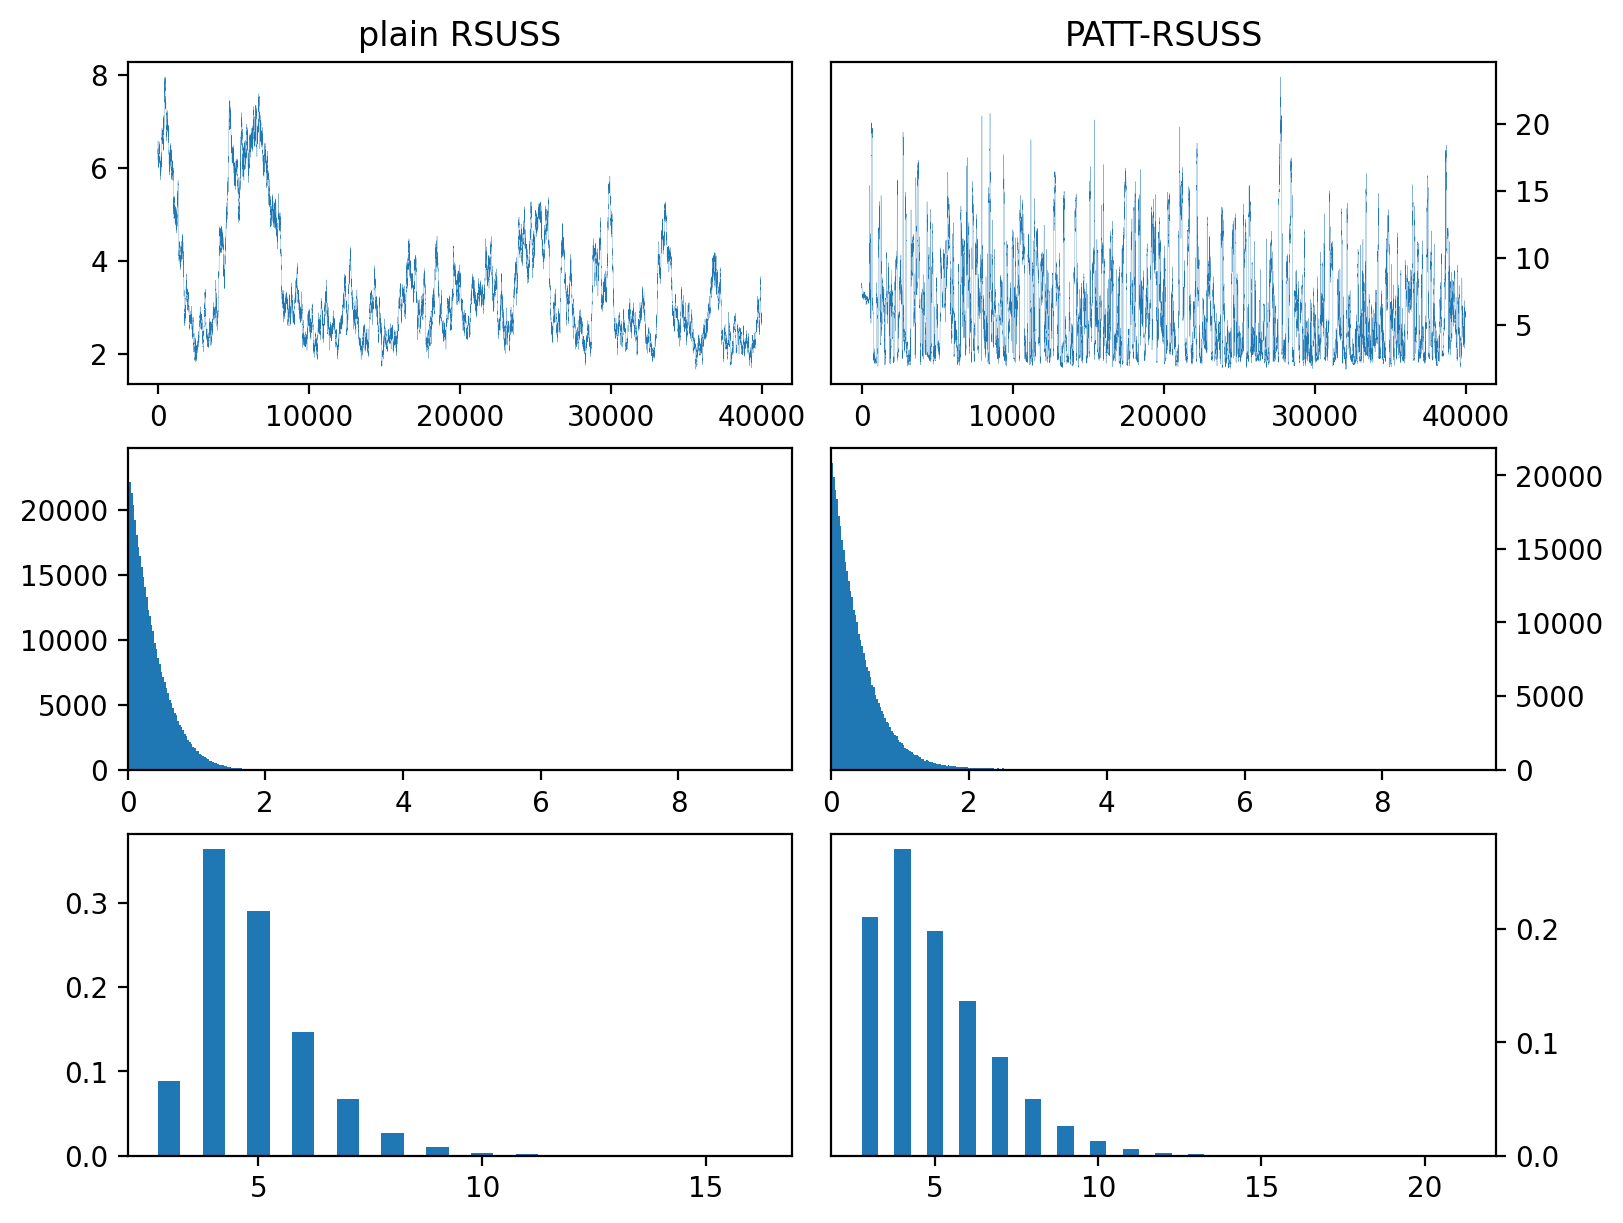

In [15]:
pfs.plot_trace_steps_tde(
    [rs[:,0] for rs in radii],
    flat_steps,
    tde,
    snames,
    filepath = path_prefix + "overview.png",
    lws=0.1
)

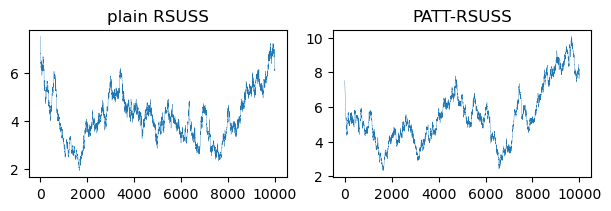

In [16]:
pfs.trace_plot_row([rs[:,0] for rs in burn_radii], snames, lws=0.25)

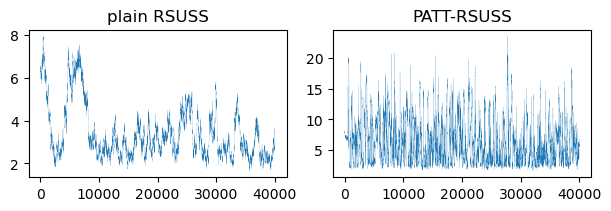

In [17]:
pfs.trace_plot_row([rs[:,0] for rs in radii], snames, lws=0.1)

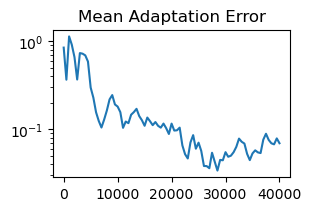

In [18]:
pfs.plot_ada_progress_testing(schedule, means, np.zeros(d), "Mean")

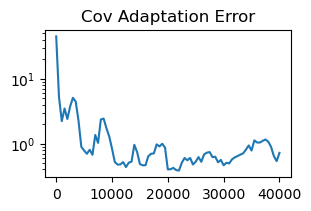

In [19]:
pfs.plot_ada_progress_testing(schedule, covs, cov, "Cov")

From the above two plots we can see on the one hand that the adaptation continued (tendentially) to improve the transformation throughout the run, but on the other hand also that the adaptation error (i.e. the difference between the parameters in use and their asymptotic values) initially dropped very quickly, meaning that the parameters only needed a few update times to reach "good" values.